# Expected Run Value Project
## Load Data

In [1]:
import requests
import pandas as pd
from io import StringIO
from big_query_utils import query_to_df

url = 'https://baseballsavant.mlb.com/statcast_search/csv?all=true&hfPT=&hfAB=&hfGT=R%7C&hfPR=&hfZ=&hfStadium=&hfBBL=&hfNewZones=&hfPull=&hfC=&hfSea=2023%7C&hfSit=&player_type=batter&hfOuts=&hfOpponent=&pitcher_throws=&batter_stands=&hfSA=&game_date_gt=&game_date_lt=&hfMo=&hfTeam=&home_road=&hfRO=&position=&hfInfield=&hfOutfield=&hfInn=&hfBBT=&hfFlag=&metric_1=&group_by=name&min_pitches=0&min_results=0&min_pas=0&sort_col=run_exp&player_event_sort=api_p_release_speed&sort_order=desc&chk_stats_woba=on&chk_stats_run_exp=on'
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.182 Safari/537.36',
    'Referer': 'https://www.fangraphs.com/roster-resource/injury-report'
}
resp = requests.get(url, headers = headers)
batter_season_orig_df = pd.read_csv(StringIO(resp.text)) \
    .rename({'player_id': 'batter'}, axis = 1) \
        .set_index('batter') \
            .loc[:, ['player_name', 'xwoba', 'run_exp']]
resp = requests.get(url.replace('player_type=batter', 'player_type=pitcher'), headers = headers)
pitcher_season_orig_df = pd.read_csv(StringIO(resp.text)) \
    .rename({'player_id': 'pitcher'}, axis = 1) \
        .set_index('pitcher') \
            .loc[:, ['player_name', 'xwoba', 'run_exp']]

in_play_df = query_to_df('''
    SELECT
        batter,
        pitcher,
        FORMAT("%s%s%s|%s",
               CASE WHEN on_1b IS NULL THEN "_" ELSE "1" END,
               CASE WHEN on_2b IS NULL THEN "_" ELSE "2" END,
               CASE WHEN on_3b IS NULL THEN "_" ELSE "3" END,
               CAST(outs_when_up AS STRING)) state,
        estimated_woba_using_speedangle,
        delta_run_exp run_exp_con
    FROM
        `mlb.statcast_pitches`
    WHERE
        game_year = 2023 AND game_type = "R" AND type = "X" AND estimated_woba_using_speedangle IS NOT NULL AND delta_run_exp IS NOT NULL;
''')

display(batter_season_orig_df)
display(pitcher_season_orig_df)
in_play_df

Successfully connected to Google Cloud project "pjb-sports-data" using service account "peteb206@pjb-sports-data.iam.gserviceaccount.com"...


,player_name,xwoba,run_exp
batter,,,
660670,"Acuña Jr., Ronald",0.460,66.6
518692,"Freeman, Freddie",0.408,64.3
621566,"Olson, Matt",0.392,63.6
605141,"Betts, Mookie",0.407,61.0
660271,"Ohtani, Shohei",0.425,53.5
...,...,...,...
657557,"DeJong, Paul",0.278,-21.1
668930,"Turang, Brice",0.274,-21.3
455117,"Maldonado, Martín",0.267,-26.4


,player_name,xwoba,run_exp
pitcher,,,
425794,"Wainwright, Adam",0.401,36.0
657756,"Seabold, Connor",0.345,34.9
543475,"Lyles, Jordan",0.339,31.1
458681,"Lynn, Lance",0.337,29.9
622663,"Severino, Luis",0.366,28.9
...,...,...,...
680694,"Bradish, Kyle",0.300,-27.5
673540,"Senga, Kodai",0.304,-28.3
543243,"Gray, Sonny",0.296,-38.0


,batter,pitcher,state,estimated_woba_using_speedangle,run_exp_con
0,658668,628711,123|0,0.132,-0.276
1,680776,687396,123|0,0.228,-0.752
2,543228,642770,123|0,0.978,-0.713
3,666969,543475,_23|0,0.020,-0.432
4,502110,543543,_23|0,0.271,-0.356
...,...,...,...,...,...
123858,592518,623433,___|2,0.098,-0.090
123859,600869,608331,___|2,0.554,-0.074
123860,670032,681911,___|2,0.280,0.179
123861,665742,601713,___|2,0.129,0.179


## Team Runs Scored vs xWOBA
to prove importance of situations, not just raw skillset

<Axes: title={'center': '2023 Team xwOBA vs. Runs Scored\nr = 0.79'}, xlabel='xwOBA', ylabel='runs'>

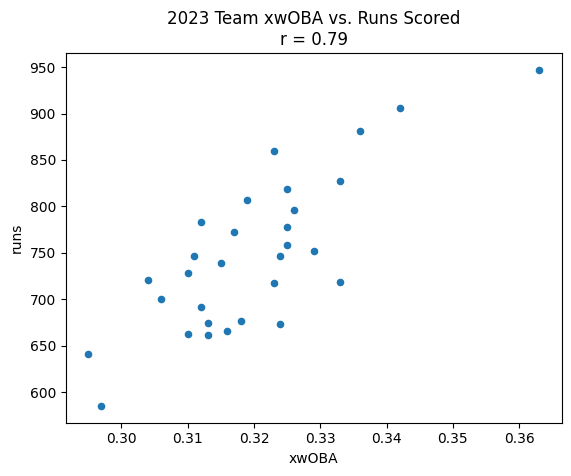

In [2]:
import json
from bs4 import BeautifulSoup
import re
from numpy import corrcoef

team_runs_df = pd.DataFrame(json.loads(requests.get('https://bdfed.stitch.mlbinfra.com/bdfed/stats/team?stitch_env=prod&sportId=1&gameType=R&group=hitting&order=desc&sortStat=onBasePlusSlugging&stats=season&season=2023&limit=30&offset=0').text)['stats']).loc[:, ['teamId', 'runs']]

resp = requests.get('https://baseballsavant.mlb.com/league?view=statcast&nav=hitting&season=2023', headers = headers)
soup = BeautifulSoup(resp.text, 'html.parser')
team_logo_and_xwOBA_df = pd.read_html(resp.text)[0]
team_logo_and_xwOBA_df.columns = [col[1] for col in team_logo_and_xwOBA_df.columns]
team_logo_and_xwOBA_df = team_logo_and_xwOBA_df.loc[:, ['XWOBA']]
team_logo_and_xwOBA_df['team_logo'] = pd.Series([img['src'] for img in soup.find('table').find_all('img')])
team_logo_and_xwOBA_df['teamId'] = team_logo_and_xwOBA_df.team_logo.apply(lambda x: re.findall(r'\d+', x)).apply(lambda x: 0 if len(x) == 0 else int(x[0]))

team_runs_vs_xwOBA_df = team_runs_df.merge(team_logo_and_xwOBA_df.query('teamId > 0'), on = 'teamId').rename({'XWOBA': 'xwOBA'}, axis = 1)
team_runs_vs_xwOBA_df.plot.scatter(x = 'xwOBA', y = 'runs', title = f'2023 Team xwOBA vs. Runs Scored\nr = {round(corrcoef(team_runs_vs_xwOBA_df.xwOBA, team_runs_vs_xwOBA_df.runs)[0][1], 2)}')

## Models

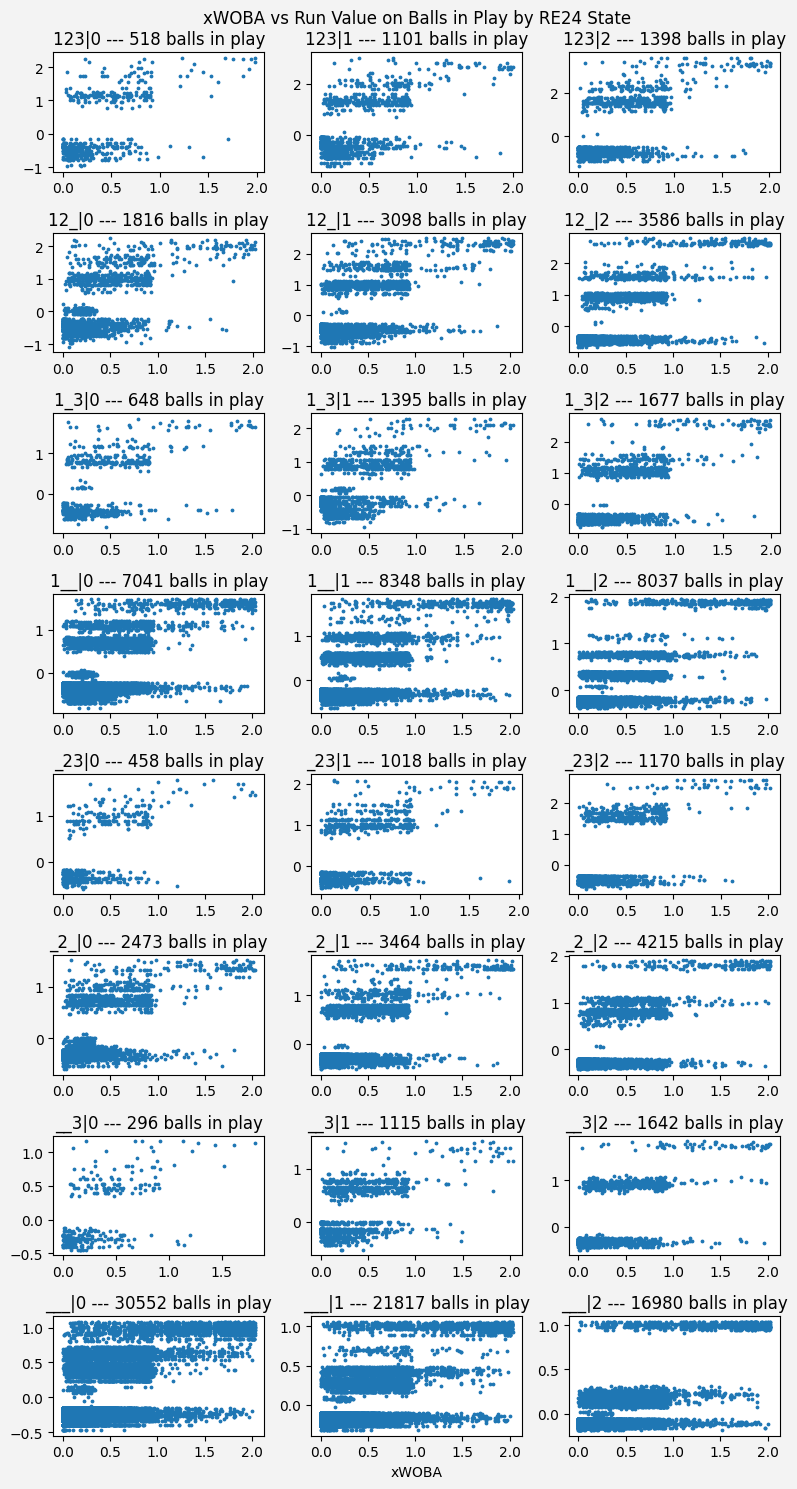

In [3]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows = 8, ncols = 3, figsize = (8, 15), facecolor = '#f3f3f3')
for state, ax in zip(sorted(in_play_df.state.unique()), axs.ravel()):
    # filter df for ticker and plot on specified axes
    scatter_df = in_play_df.loc[in_play_df.state == state]
    ax.scatter(x = scatter_df.estimated_woba_using_speedangle, y = scatter_df.run_exp_con, s = 3)

    # chart formatting
    title = f'{state} --- {len(in_play_df.loc[in_play_df.state == state].index)} balls in play'
    if state == '123|1':
        title = f'xWOBA vs Run Value on Balls in Play by RE24 State\n{title}'
    ax.set_title(title)

    x_label = ''
    if state == '___|1':
        x_label = 'xWOBA'
    ax.set_xlabel(x_label)

fig.tight_layout()
plt.show()

### Multiple Linear Regression

In [4]:
from statsmodels.formula.api import ols
import numpy as np

lm = ols('run_exp_con ~ C(state) + estimated_woba_using_speedangle', data = in_play_df).fit()
print('RMSE:', round(np.sqrt(np.mean((lm.predict(in_play_df) - in_play_df.run_exp_con) ** 2)), 3))

RMSE: 0.433


### KNN

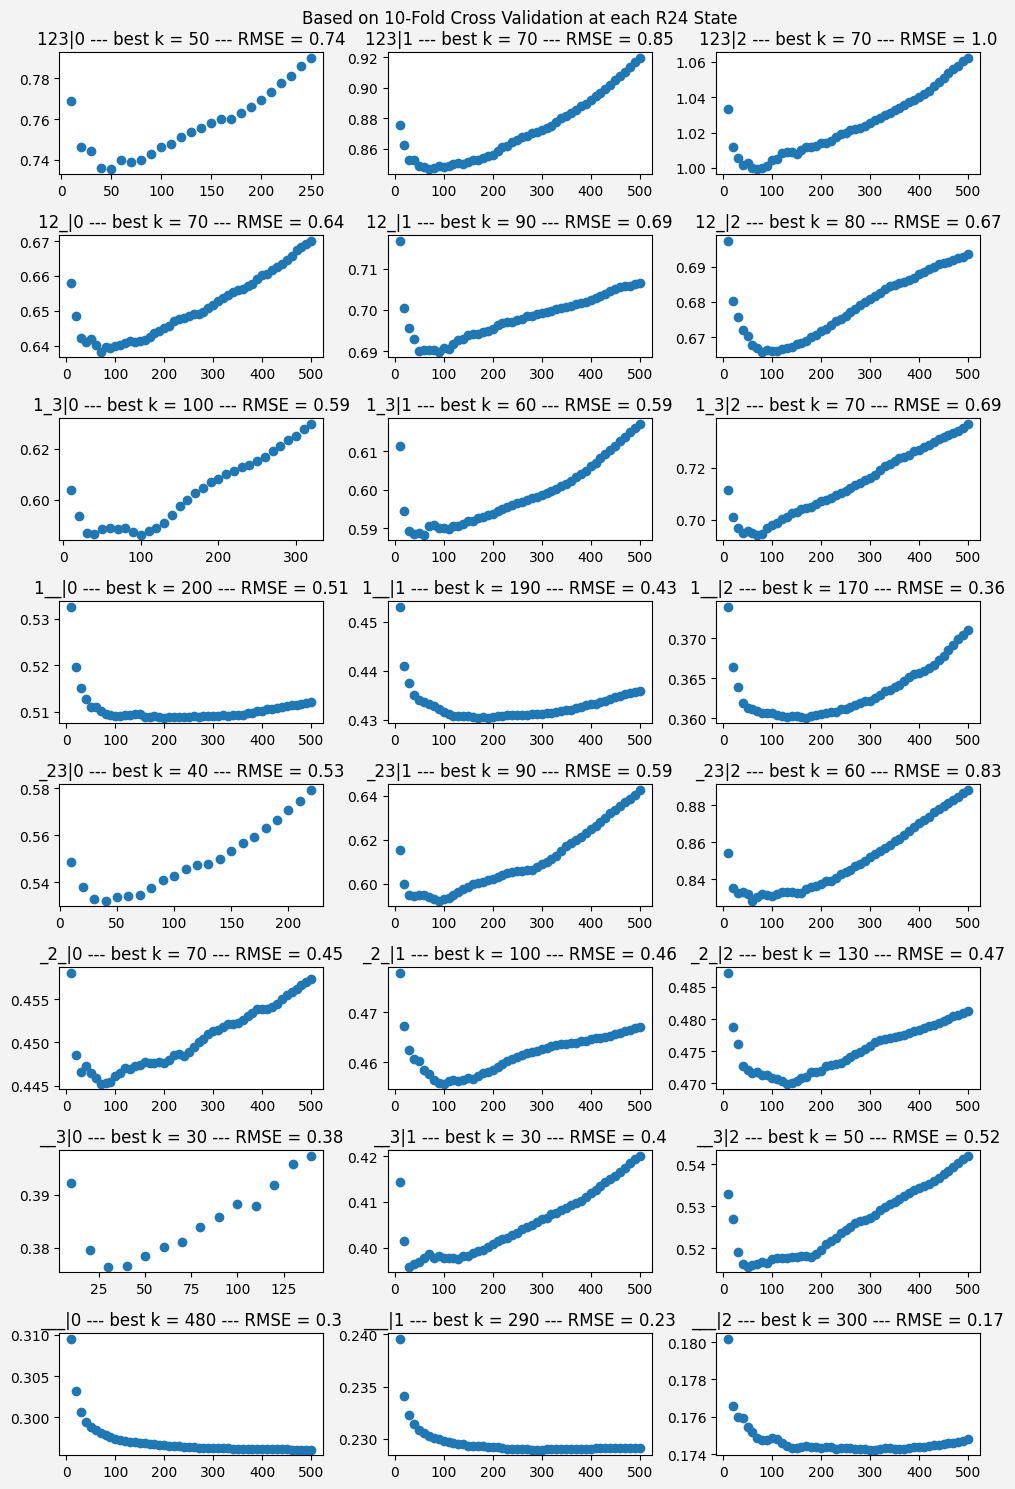

RMSE: 0.405


In [5]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

knns_by_state = dict()
fig, axs = plt.subplots(nrows = 8, ncols = 3, figsize = (10, 15), facecolor = '#f3f3f3')
for state, ax in zip(sorted(in_play_df.state.unique()), axs.ravel()):
    X = in_play_df.loc[in_play_df.state == state, ['estimated_woba_using_speedangle']].to_numpy()
    y = in_play_df.loc[in_play_df.state == state, 'run_exp_con'].to_numpy()

    rmses = list()
    k_values = list(range(10, min(510, int(len(y) / 2)), 10))
    best_k, best_rmse = 0, 10000000
    for k in k_values:
        neg_mean_squared_errors = cross_val_score(KNeighborsRegressor(n_neighbors = k), X, y, cv = 10, scoring = 'neg_mean_squared_error')
        rmse = np.mean(np.sqrt(np.abs(neg_mean_squared_errors)))
        if rmse < best_rmse:
            best_k = k
            best_rmse = rmse
        rmses.append(rmse)
    ax.scatter(k_values, rmses)

    title = f'{state} --- best k = {best_k} --- RMSE = {round(min(rmses), 2)}'
    if state == '123|1':
        title = f'Based on 10-Fold Cross Validation at each R24 State\n{title}'
    ax.set_title(title)

    x_label = ''
    if state == '___|1':
        x_label = 'k'

    knns_by_state[state] = KNeighborsRegressor(n_neighbors = best_k).fit(X, y)
fig.tight_layout()
plt.show()
y_pred = in_play_df.apply(lambda row: knns_by_state[row['state']].predict([[row['estimated_woba_using_speedangle']]])[0], axis = 1)
print('RMSE:', round(np.sqrt(np.mean((y_pred - in_play_df.run_exp_con) ** 2)), 3))

The RE24 state-specific KNN models provide the best RMSE

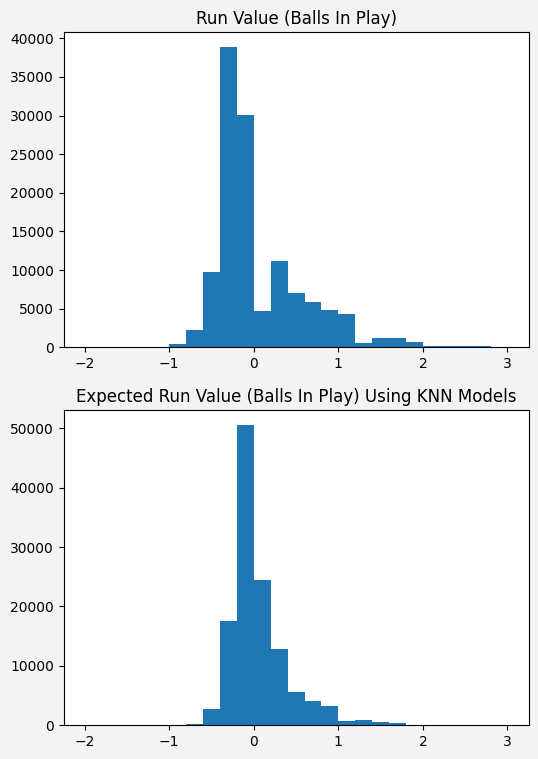

In [6]:
in_play_df['x_run_exp_con'] = in_play_df.apply(lambda row: knns_by_state[row['state']].predict([[row['estimated_woba_using_speedangle']]])[0], axis = 1)

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (6, 9), facecolor = '#f3f3f3')
axs[0].hist(in_play_df.run_exp_con, range = (-2, 3), bins = 25)
axs[0].set_title('Run Value (Balls In Play)')
axs[1].hist(in_play_df.x_run_exp_con, range = (-2, 3), bins = 25)
axs[1].set_title('Expected Run Value (Balls In Play) Using KNN Models')
plt.show()

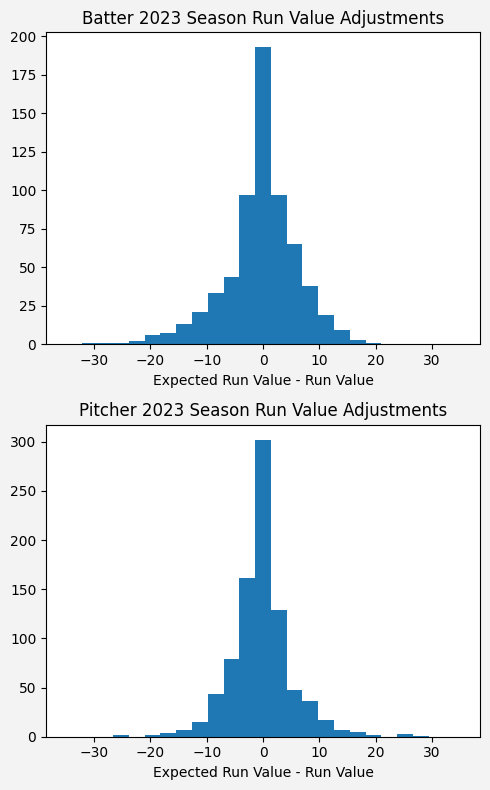

In [7]:
batter_adjustments_df = in_play_df.groupby('batter')[['run_exp_con', 'x_run_exp_con']].sum()
batter_adjustments_df['adj'] = batter_adjustments_df.x_run_exp_con - batter_adjustments_df.run_exp_con

pitcher_adjustments_df = in_play_df.groupby('pitcher')[['run_exp_con', 'x_run_exp_con']].sum()
pitcher_adjustments_df['adj'] = pitcher_adjustments_df.x_run_exp_con - pitcher_adjustments_df.run_exp_con

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (5, 8), facecolor = '#f3f3f3')
axs[0].hist(batter_adjustments_df.adj, range = (-35, 35), bins = 25)
axs[0].set_title('Batter 2023 Season Run Value Adjustments')
axs[0].set_xlabel('Expected Run Value - Run Value')
axs[1].hist(pitcher_adjustments_df.adj, range = (-35, 35), bins = 25)
axs[1].set_title('Pitcher 2023 Season Run Value Adjustments')
axs[1].set_xlabel('Expected Run Value - Run Value')
fig.tight_layout()
plt.show()

In [8]:
batter_season_df = batter_season_orig_df.merge(batter_adjustments_df, left_index = True, right_index = True)
batter_season_df['x_run_exp'] = batter_season_df.run_exp + batter_season_df.adj
batter_season_df['Rank'] = batter_season_df.run_exp.rank(method = 'min', ascending = False).astype(int)
batter_season_df['Adjusted Rank'] = batter_season_df.x_run_exp.rank(method = 'min', ascending = False).astype(int)
batter_season_df['Rank Change'] = batter_season_df['Rank'] - batter_season_df['Adjusted Rank']
batter_season_df

,player_name,xwoba,run_exp,run_exp_con,x_run_exp_con,adj,x_run_exp,Rank,Adjusted Rank,Rank Change
batter,,,,,,,,,,
660670,"Acuña Jr., Ronald",0.460,66.6,57.865,72.177302,14.312302,80.912302,1,1,0
518692,"Freeman, Freddie",0.408,64.3,75.167,68.576799,-6.590201,57.709799,2,4,-2
621566,"Olson, Matt",0.392,63.6,76.218,61.031220,-15.186780,48.413220,3,8,-5
605141,"Betts, Mookie",0.407,61.0,51.740,52.264799,0.524799,61.524799,4,2,2
660271,"Ohtani, Shohei",0.425,53.5,68.542,60.873910,-7.668090,45.831910,5,9,-4
...,...,...,...,...,...,...,...,...,...,...
657557,"DeJong, Paul",0.278,-21.1,4.317,13.892224,9.575224,-11.524776,647,596,51
668930,"Turang, Brice",0.274,-21.3,1.484,1.617759,0.133759,-21.166241,648,643,5
455117,"Maldonado, Martín",0.267,-26.4,3.868,8.467229,4.599229,-21.800771,649,645,4


In [9]:
pitcher_season_df = pitcher_season_orig_df.merge(pitcher_adjustments_df, left_index = True, right_index = True)
pitcher_season_df['x_run_exp'] = pitcher_season_df.run_exp + pitcher_season_df.adj
pitcher_season_df['Rank'] = pitcher_season_df.run_exp.rank(method = 'min', ascending = True).astype(int)
pitcher_season_df['Adjusted Rank'] = pitcher_season_df.x_run_exp.rank(method = 'min', ascending = True).astype(int)
pitcher_season_df['Rank Change'] = pitcher_season_df['Rank'] - pitcher_season_df['Adjusted Rank']
pitcher_season_df.sort_values('run_exp', inplace = True)
pitcher_season_df

,player_name,xwoba,run_exp,run_exp_con,x_run_exp_con,adj,x_run_exp,Rank,Adjusted Rank,Rank Change
pitcher,,,,,,,,,,
543037,"Cole, Gerrit",0.289,-44.6,1.001,17.794437,16.793437,-27.806563,1,2,-1
605483,"Snell, Blake",0.301,-43.8,-8.404,15.518487,23.922487,-19.877513,2,8,-6
543243,"Gray, Sonny",0.296,-38.0,-4.437,15.827351,20.264351,-17.735649,3,18,-15
673540,"Senga, Kodai",0.304,-28.3,2.740,20.994083,18.254083,-10.045917,4,81,-77
680694,"Bradish, Kyle",0.300,-27.5,1.916,19.271897,17.355897,-10.144103,5,80,-75
...,...,...,...,...,...,...,...,...,...,...
622663,"Severino, Luis",0.366,28.9,47.323,27.824385,-19.498615,9.401385,859,804,55
458681,"Lynn, Lance",0.337,29.9,55.434,44.891153,-10.542847,19.357153,860,850,10
543475,"Lyles, Jordan",0.339,31.1,42.627,40.761143,-1.865857,29.234143,861,861,0


## Results

In [10]:
from pyperclip import copy

def to_markdown(df, sort_by = '', ascending = True):
    df['image'] = df.index.to_series().apply(lambda x: f'<img src="https://content.mlb.com/images/headshots/current/60x60/{x}.png" width="40px">')
    df['Adjusted Rank HTML'] = df.apply(lambda row: f'{row["Adjusted Rank"]} (<span style="color: {"red" if row["Rank Change"] < 0 else "green"};"><i class="fa-solid fa-arrow-{"down" if row["Rank Change"] < 0 else "up"}"></i> {abs(row["Rank Change"])}</span>)', axis = 1)
    df['Adjusted Rank HTML'] = df['Adjusted Rank HTML'].apply(lambda x: x.split('(')[0] if x.endswith('> 0</span>)') else x)
    df['Player'] = df.apply(lambda row: row['image'] + row['player_name'], axis = 1)
    df['Exp. Run Value'] = df.x_run_exp.round(1).apply(lambda x: f'<span>{x}</span>')
    df['Run Value'] = df.run_exp.round(1).apply(lambda x: f'<span>{x}</span>')
    df['+/-'] = df.adj.round(1).apply(lambda x: '<span style="color: ' + (f'green;">+{x}' if x > 0 else f'red;">{x}' if x < 0 else f'#343434;">{x}') + '</span>')
    print_df = df.sort_values(sort_by, ascending = ascending).loc[:, ['Adjusted Rank HTML', 'Player', 'Run Value', 'Exp. Run Value', '+/-']].rename({'Adjusted Rank HTML': 'Rank (<i class="fa-solid fa-arrow-up"></i><i class="fa-solid fa-arrow-down"></i>)'}, axis = 1).replace('\.0', '', regex = True)
    print_str = print_df.head(10).to_markdown(index = False)
    print_df.columns = ['...' for _ in print_df.columns]
    print_str += f'\n{print_df.tail(10).to_markdown(index = False)}'
    return print_str

copy('\n\n'.join([to_markdown(batter_season_df, sort_by = 'Adjusted Rank', ascending = True),
                  to_markdown(pitcher_season_df, sort_by = 'Adjusted Rank', ascending = True),
                  to_markdown(batter_season_df, sort_by = 'adj', ascending = False),
                  to_markdown(pitcher_season_df, sort_by = 'adj', ascending = False)]))

In [11]:
in_play_df['diff'] = in_play_df.x_run_exp_con - in_play_df.run_exp_con
in_play_df.sort_values('diff', inplace = True)
display(in_play_df.head(3))
display(in_play_df.tail(3))

,batter,pitcher,state,estimated_woba_using_speedangle,run_exp_con,x_run_exp_con,diff
3239,670623,686610,123|2,0.066,3.353,-0.534357,-3.887357
3160,663616,666154,123|2,0.246,3.430,-0.136729,-3.566729
1807,663368,668933,123|1,0.140,2.802,-0.347229,-3.149229


,batter,pitcher,state,estimated_woba_using_speedangle,run_exp_con,x_run_exp_con,diff
2894,656582,673540,123|2,1.746,-0.734,2.505843,3.239843
2662,664034,672582,123|2,1.627,-0.875,2.505843,3.380843
2895,628451,682847,123|2,1.612,-0.875,2.505843,3.380843
